In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from ANEMO import read_edf
import numpy as np
%matplotlib inline

In [2]:
import glob
liste = {'pari':{}, 'enregistrement':{}}

for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste[a[0]][a[1]] = a[2]+'_'+a[3]

SUJETS = ['AM'] #liste['pari'].keys()
data, exp = {}, {}

for s in SUJETS :
    with open('data/pari_%s_%s.pkl'%(s, liste['pari'][s]), 'rb') as fichier :
        exp[s] = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('..','data', 'enregistrement_' + s + '_' + liste['enregistrement'][s] + '.asc')
    data[s] = read_edf(resultats, 'TRIALID')

In [3]:
from ANEMO import ANEMO
from aSPEM import Analysis

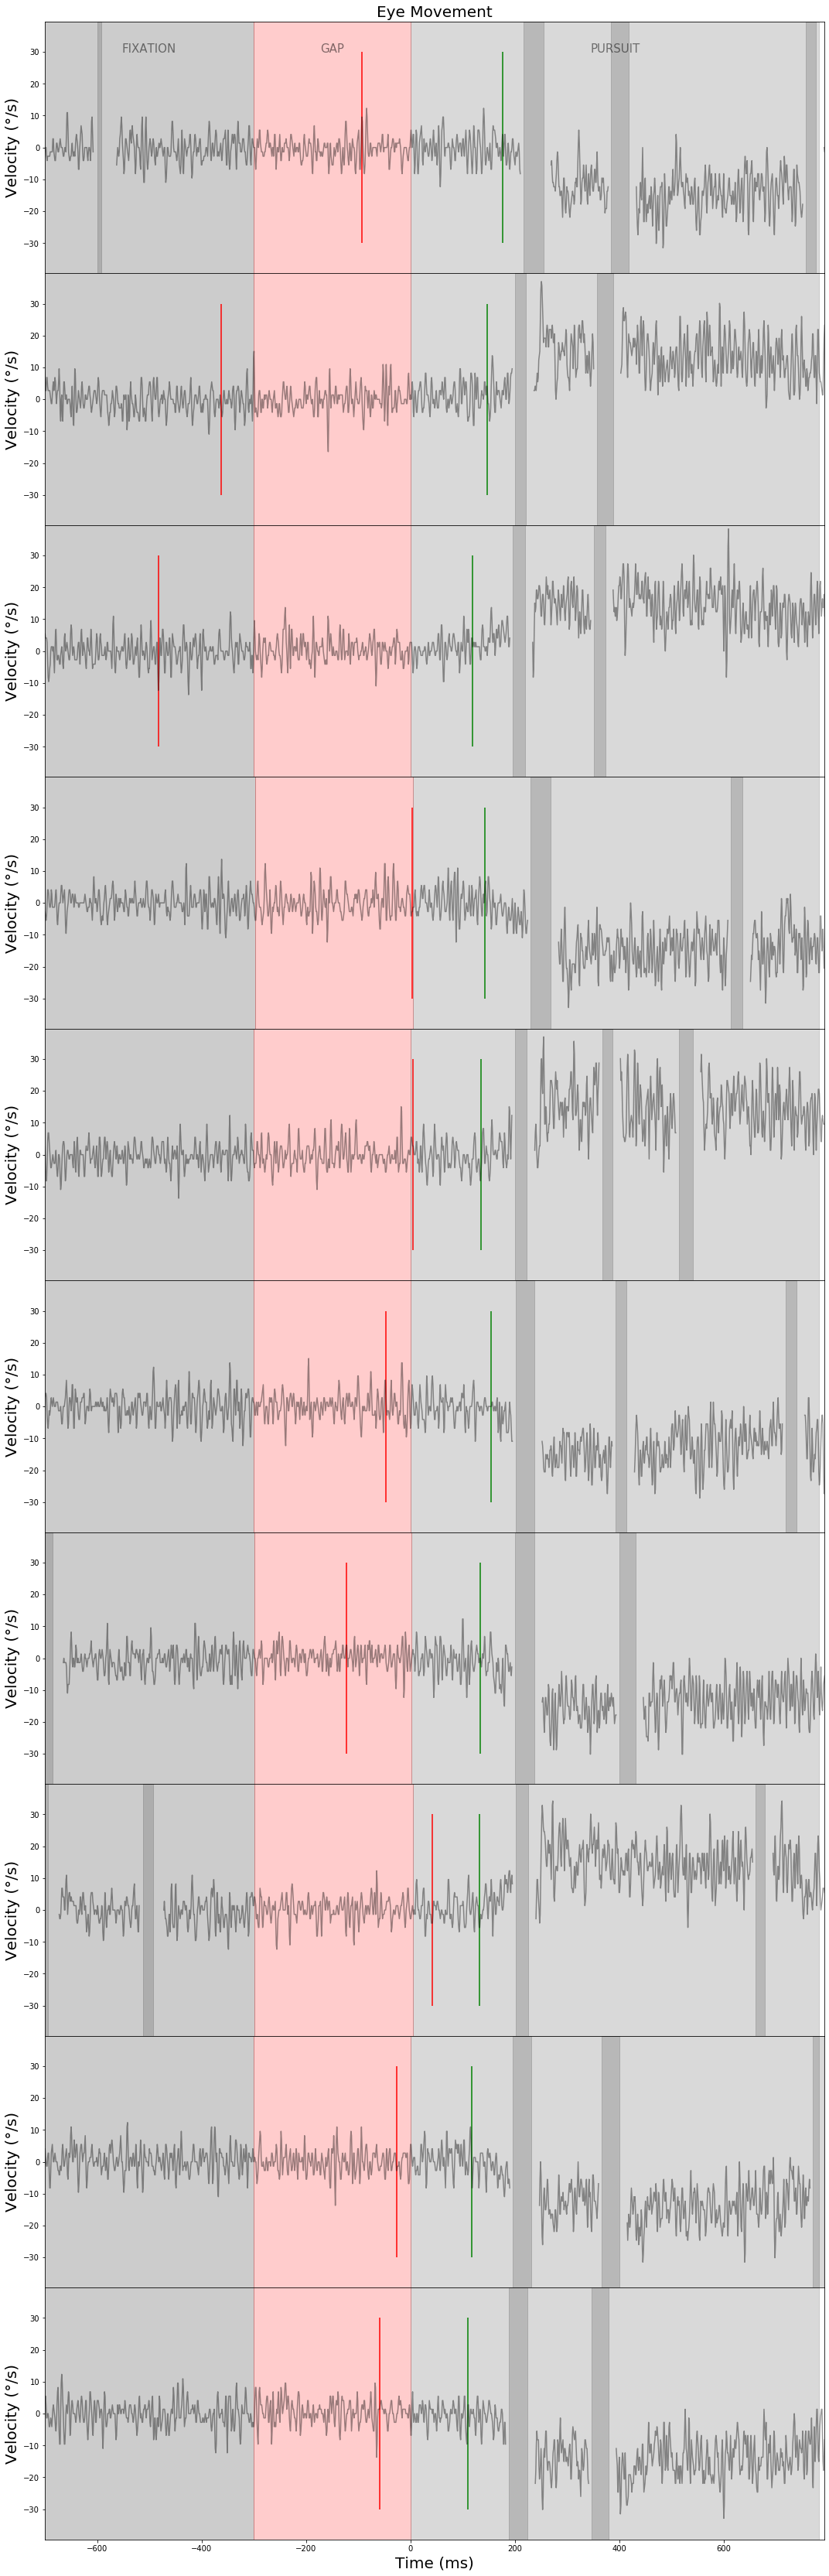

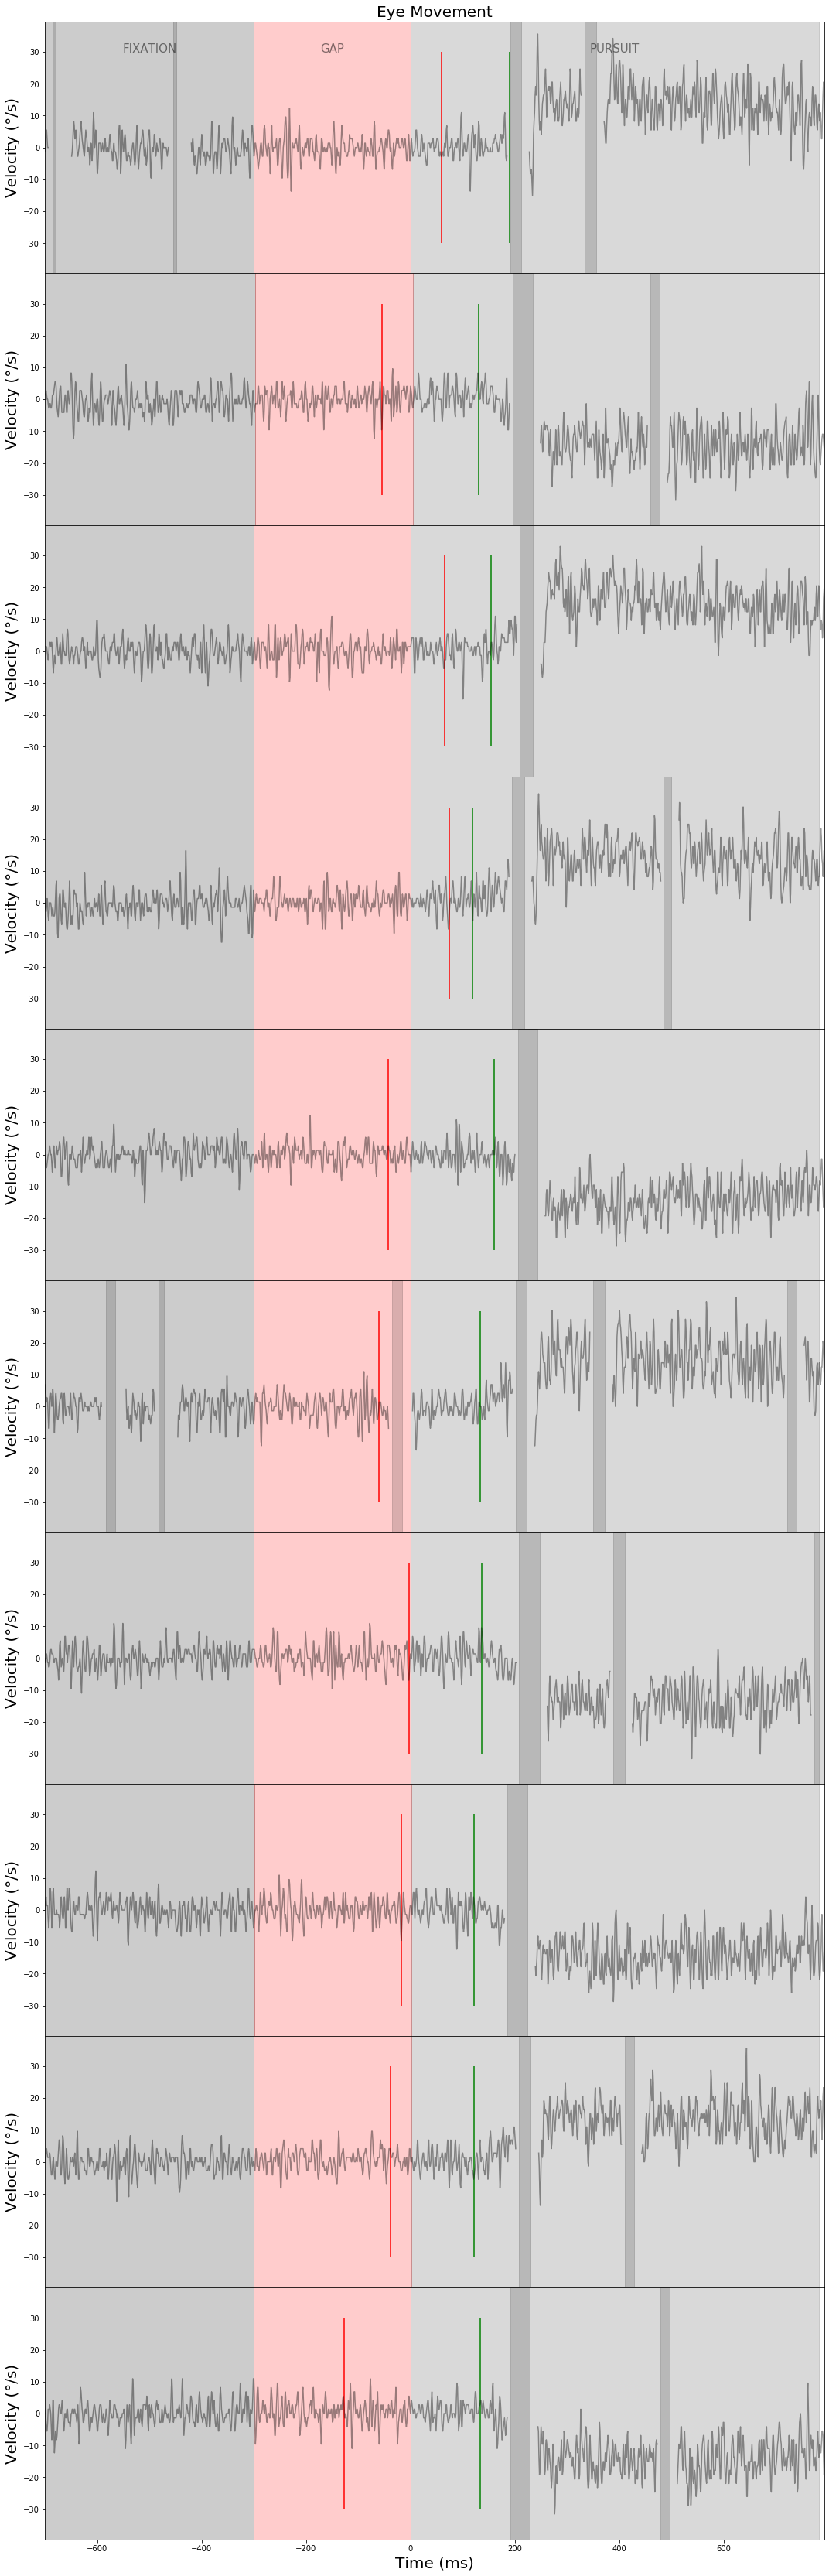

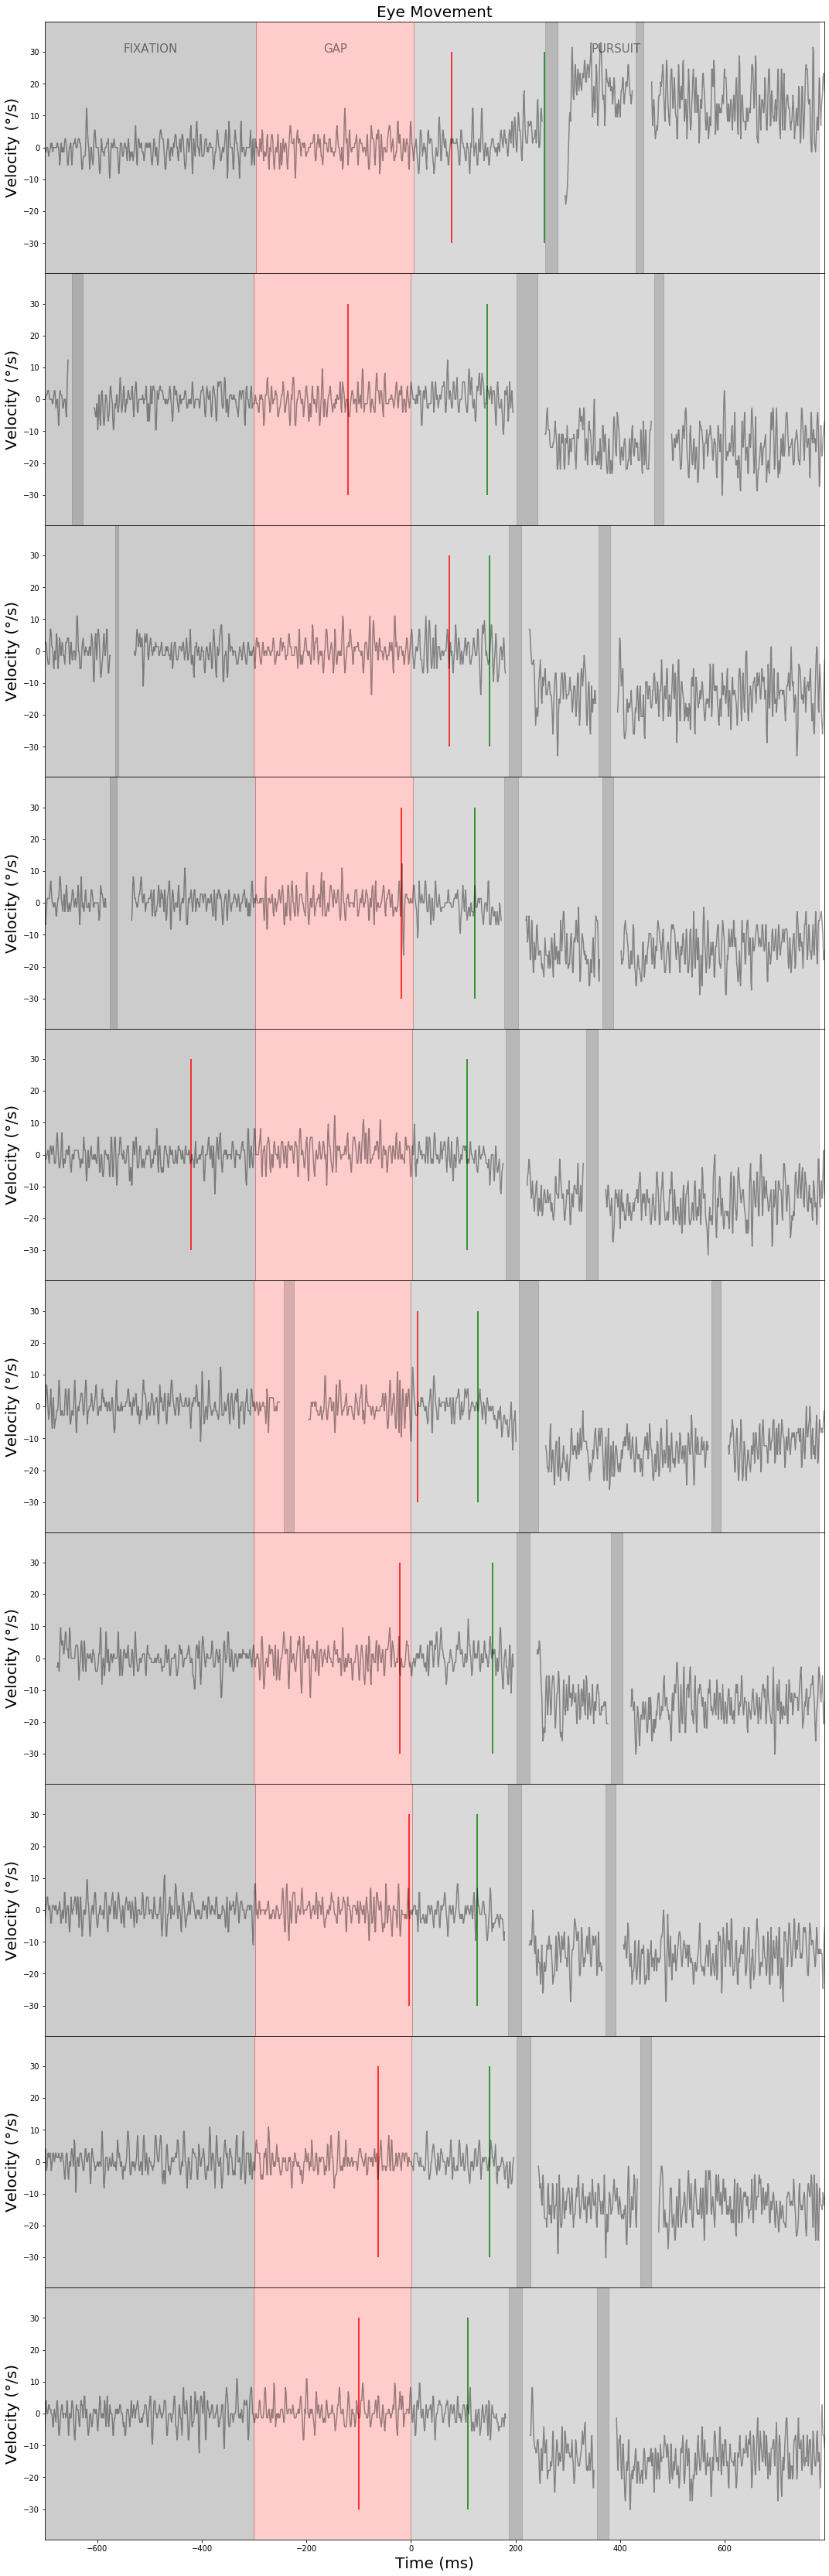

In [4]:
size, size_anti, size_latency = [], [], []

size_switch, size_anti_switch, size_latency_switch = [], [], []
size_noswitch, size_anti_noswitch, size_latency_noswitch = [], [], []
do_mean = False

for s in SUJETS :
    e = Analysis(observer=s, name_file_fit='fct_velocity_sigmo')

    A = ANEMO(exp[s]) 
    N_blocks, N_trials = exp[s]['N_blocks'], exp[s]['N_trials']
    
    
    for block in range(N_blocks) :
        
        fig, ax = e.plot_data(trials=list(np.arange(10)), block=block)
        
        switch = np.where(exp[s]['p'][:, block, 2]==1)[0]
        
        for trial in range(N_trials) :
            trial_data = trial + N_trials*block
            arg = A.arg(data[s][trial_data], trial=trial, block=block)
            
            TarOn_0 = arg.TargetOn-arg.t_0
            start = TarOn_0-700
            stop = TarOn_0+800
            tps = arg.trackertime[start:stop]-arg.TargetOn
            
            start_anti = e.ENREGISTREMENT[s]['start_anti'][block][trial]
            latency = e.ENREGISTREMENT[s]['latency'][block][trial]
            
            
            taille = data[s][trial_data]['size']
            
            for sacc in arg.saccades :
                taille[sacc[0]-arg.t_0 -5 : sacc[1]-arg.t_0 +15] = np.nan
            
            
            taille_anti = taille[int(start_anti)+TarOn_0-300:int(start_anti)+TarOn_0+300]
            if do_mean: taille_anti = taille_anti/np.nanmean(taille_anti)
            size_anti.append(taille_anti)
            
            
            taille_latency = taille[int(latency)+TarOn_0-300:int(latency)+TarOn_0+300]
            if do_mean: taille_latency = taille_latency/np.nanmean(taille_latency)
            size_latency.append(taille_latency)
            
            
            taille = taille[start:stop]
            if do_mean: taille = taille/np.nanmean(taille)
            size.append(taille)
            
            
            swiswi=False
            
            for sw in switch :
                if trial in np.arange(sw+2, sw+7) :
                    #print(trial)
                    swiswi=True
                    size_switch.append(taille)
                    size_anti_switch.append(taille_anti)
                    size_latency_switch.append(taille_latency)
            
            if swiswi is False:
                size_noswitch.append(taille)
                size_anti_noswitch.append(taille_anti)
                size_latency_noswitch.append(taille_latency)
            
            
            
            if trial<10 :
                ax[trial].plot(tps, 100*taille - 100, c='r' )
                ax[trial].vlines(start_anti, -30, 30, color='r')
                ax[trial].vlines(latency, -30, 30, color='g')
        plt.show()

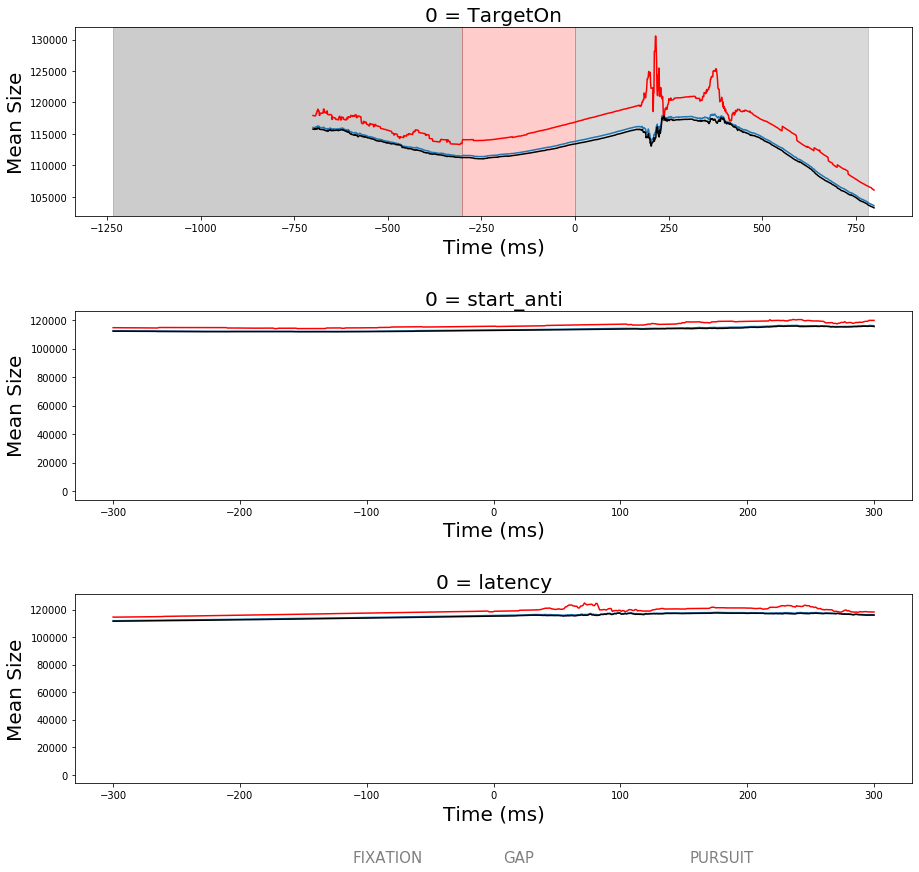

In [5]:
fig_width=15
t_label, t_text = 20, 14

fig, ax = plt.subplots(3, 1, figsize=(fig_width, 3*(fig_width*(1/2))/1.6180))
fig.subplots_adjust(hspace=0.5)


start = arg.TargetOn
time_s = arg.trackertime-start
TarOn_s, TarOff_s  = arg.TargetOn-start,   arg.TargetOff-start
StimOn_s, StimOf_s = arg.StimulusOn-start, arg.StimulusOf - start

onset = arg.TargetOn-arg.t_0
start, stop = onset-700, onset+800
tps = time_s[start:stop]

for i in range(len(ax)) :
    ax[i].set_ylabel('Mean Size', fontsize=t_label, color='k')
    ax[i].set_xlabel('Time (ms)', fontsize=t_label, color='k')


ax[0].set_title('0 = TargetOn', fontsize=t_label, color='k')
if do_mean: ax[0].axis([TarOn_s-700, TarOff_s+10, -10, 10])

ax[0].axvspan(StimOn_s, StimOf_s, color='k', alpha=0.2)
ax[0].axvspan(StimOf_s, TarOn_s,  color='r', alpha=0.2)
ax[0].axvspan(TarOn_s,  TarOff_s, color='k', alpha=0.15)

ax[0].text(StimOf_s+(TarOn_s-StimOf_s)/2,            8, "GAP",      color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)
ax[0].text((TarOn_s-700)+(StimOf_s-(TarOn_s-700))/2, 8, "FIXATION", color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)
ax[0].text(TarOn_s+(TarOff_s-TarOn_s)/2,             8, "PURSUIT",  color='k', size=t_label*.75, ha='center', va='center', alpha=0.5)

ax[0].plot(tps, 100*np.nanmean(size, axis=0)-100)
ax[0].plot(tps, 100*np.nanmean(size_switch, axis=0)-100, c='r')
ax[0].plot(tps, 100*np.nanmean(size_noswitch, axis=0)-100, c='k')


tps_anti = np.linspace(-300, 300, len(size_anti[0]))

for i, c in enumerate(['r', 'g']) :

    if do_mean: ax[i+1].axis([-300, 300, -5, 5])
    ax[i+1].vlines(0, -9, 9, color=c)

ax[1].set_title('0 = start_anti', fontsize=t_label, color='k')
ax[1].plot(tps_anti, 100*np.nanmean(size_anti, axis=0)-100)
ax[1].plot(tps_anti, 100*np.nanmean(size_anti_switch, axis=0)-100, c='r')
ax[1].plot(tps_anti, 100*np.nanmean(size_anti_noswitch, axis=0)-100, c='k')

ax[2].set_title('0 = latency', fontsize=t_label, color='k')
ax[2].plot(tps_anti, 100*np.nanmean(size_latency, axis=0)-100)
ax[2].plot(tps_anti, 100*np.nanmean(size_latency_switch, axis=0)-100, c='r')
ax[2].plot(tps_anti, 100*np.nanmean(size_latency_noswitch, axis=0)-100, c='k')

plt.show()